In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import gridspec
import copy
import os
from tqdm import tqdm 

from EightBitTransit.cTransitingImage import TransitingImage
from EightBitTransit.inversion import *
from EightBitTransit.misc import *
from scipy.optimize import lsq_linear

%matplotlib inline


import matplotlib.path as mpath
import matplotlib.patches as mpatches
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Polygon
from matplotlib.patches import Rectangle
from matplotlib.patches import Wedge


from PIL import Image 


# Add spocc directory to the path to import spocc modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import data
import loaders


# These "magic" functions work in jupyter notebooks, this one reloads
# modules so if you make changes, you don't have to restart the notebook.
%load_ext autoreload
%autoreload 2

Flux at mid transit  0.01  0.04  0.09  0.16  0.24  0.34  0.45  0.58  0.70  \
Width                                                                       
1.0                   0.6   0.6   0.4   0.0   0.0   0.0   0.0   0.0   0.0   
2.0                   0.6   0.6   0.6   0.6   0.6   0.6   0.6   0.2   0.0   
3.0                   0.7   0.7   0.7   0.7   0.6   0.6   0.6   0.6   0.2   
4.0                   0.8   0.8   0.8   0.8   0.8   0.7   0.7   0.6   0.3   
5.0                   0.8   0.8   0.8   0.8   0.8   0.8   0.8   0.7   0.5   
6.0                   0.9   0.9   0.9   0.8   0.8   0.8   0.8   0.7   0.5   

Flux at mid transit  0.82  0.96  0.98  
Width                                  
1.0                   0.0   0.0   0.0  
2.0                   0.0   0.0   0.0  
3.0                   0.0   0.0   0.0  
4.0                   0.0   0.0   0.0  
5.0                   0.0   0.0   0.0  
6.0                   0.0   0.0   0.0  


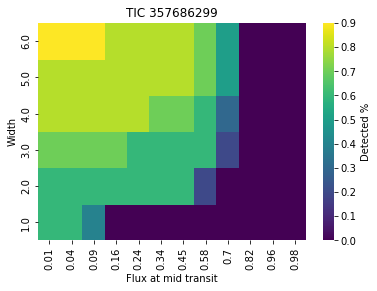

In [2]:
mag_bin = 14
tic =  357686299 #422305731
data = pd.read_csv(f'./heatmap_data_mag_{mag_bin}/{tic}_heatmap.csv')
data_pivoted = data.pivot("Width", "Flux at mid transit", "Detected")
print(data_pivoted)

data_pivoted = sns.heatmap(data_pivoted, cmap="viridis")


plt.title(f"TIC {tic}")
data_pivoted.collections[0].colorbar.set_label("Detected %")
data_pivoted.invert_yaxis()
plt.show()


In [3]:
# Mount data either from disk or bucket

data_dir = "/home/jupyter/mountpoint/"  # path for bucket

ref = loaders.load_ref(18, data_dir) #sector 18 camera 2

#subref = ref[ref.TIC_ID.isin([251630511])]#377199128 # overplot with this anomalous
subref = ref.loc[ref['Magnitude']>14]
print(subref)
tic_id = data_dir+subref.Filename.values[0]
tic_id = tic_id.split('_')[-1].split('.')[0]
print(tic_id)

                                                  Filename          RA  \
35       tesslcs_sector_18_104/2_min_cadence_targets/te...  275.124111   
50       tesslcs_sector_18_104/2_min_cadence_targets/te...   16.249241   
83       tesslcs_sector_18_104/2_min_cadence_targets/te...  283.291254   
141      tesslcs_sector_18_104/2_min_cadence_targets/te...  237.779619   
232      tesslcs_sector_18_104/2_min_cadence_targets/te...  357.036408   
...                                                    ...         ...   
2841738  tesslcs_sector_18_104/tesslcs_tmag_14_15/tessl...  250.551325   
2841739  tesslcs_sector_18_104/tesslcs_tmag_14_15/tessl...  250.665413   
2841740  tesslcs_sector_18_104/tesslcs_tmag_14_15/tessl...  250.632074   
2841741  tesslcs_sector_18_104/tesslcs_tmag_14_15/tessl...  239.338353   
2841742  tesslcs_sector_18_104/tesslcs_tmag_14_15/tessl...  263.168704   

               Dec      TIC_ID  Sector  Camera  CCD  Magnitude  
35       58.078045   357686299      18       4

In [17]:
def average_heatmaps(folder_path, mag_bin, many = False):
    heatmap_files = [file for file in os.listdir(folder_path) if file.endswith(f'_heatmap.csv')]
    if len(heatmap_files) == 0:
        print("No heatmap files found in the specified folder.")
        return

    # Initialize an empty DataFrame to store the sum of heatmaps
    sum_heatmap = None

    for file in heatmap_files:
        file_path = os.path.join(folder_path, file)
        data = pd.read_csv(file_path)
        data["Detected"] = data["Detected"].multiply(100)
        data_pivoted = data.pivot("Width", "Flux at mid transit", "Detected")

        
        # If it's the first file, set the sum_heatmap to the current heatmap
        if sum_heatmap is None:
            sum_heatmap = data_pivoted
        else:
            # Add the current heatmap to the sum_heatmap
            sum_heatmap += data_pivoted
        if many == True:
            single_data_pivoted = sns.heatmap(data_pivoted, cmap="viridis")#, vmin=0, vmax=1)

            plt.title(f"TIC {file[:-12]} (mag bin {mag_bin})")
            single_data_pivoted.collections[0].colorbar.set_label("Detected Fraction")
            single_data_pivoted.invert_yaxis()
            plt.show()
            tic_id = int(file[:-12])
            print(tic_id)
            subref = ref[ref.TIC_ID==tic_id] 
            f0 = data_dir+subref.Filename.values[0]
            lc = loaders.load_lc(f0)
            lc = lc[lc.quality==0]
            lc = lc.normalize()
            time = lc.time.value
            time = [value - time[0] for value in time] #make time start at 0
            plt.plot(time, lc.flux.value)
            plt.title(tic_id)
            plt.show()

    # Calculate the average heatmap by dividing the sum_heatmap by the number of files
    #print(sum_heatmap)
    average_heatmap = sum_heatmap / len(heatmap_files)
    #print(average_heatmap)
    # Plot the averaged heatmap
    ax = sns.heatmap(average_heatmap, cmap="viridis", vmin=0, vmax=100)
    plt.title(f"Averaged Heatmap for Mag Bin {mag_bin}")
    plt.xlabel("Flux at mid transit")
    plt.ylabel("Width (Days)")
    ax.invert_yaxis()

    cbar = ax.collections[0].colorbar
    cbar.set_label("Detected %")

    plt.show()

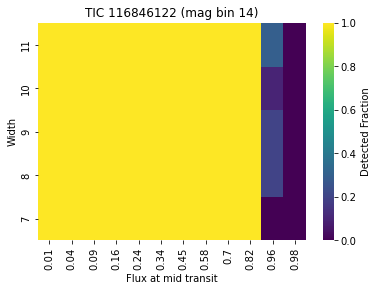

116846122


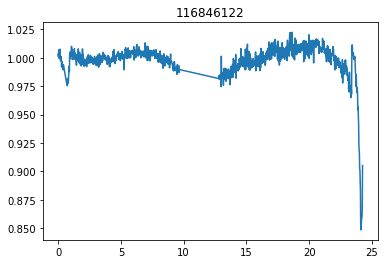

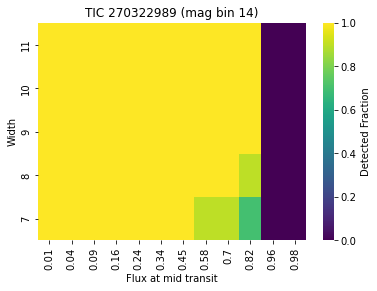

270322989


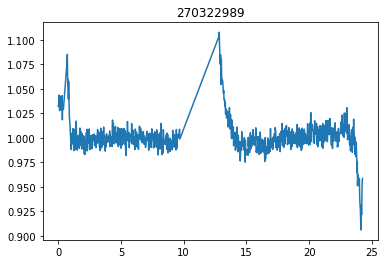

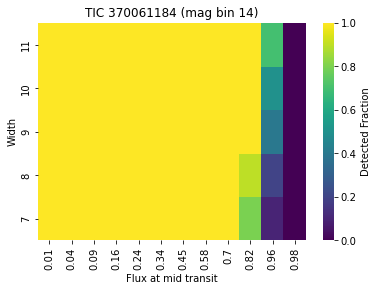

370061184


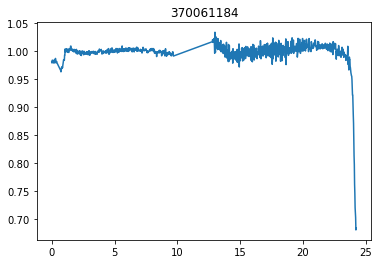

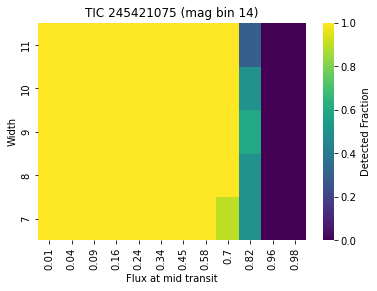

245421075


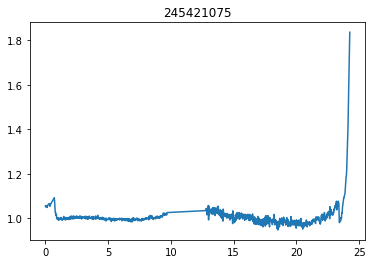

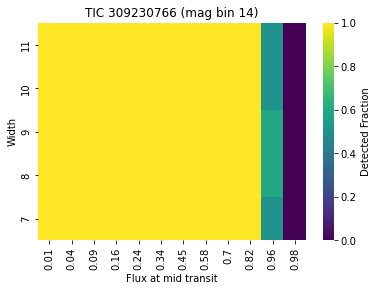

309230766


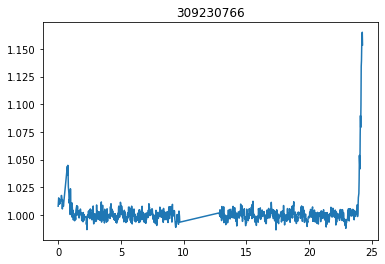

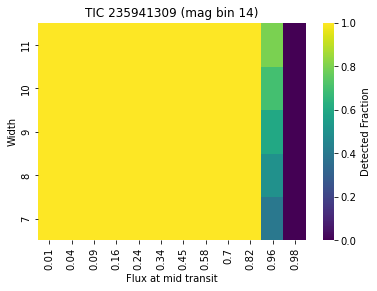

235941309


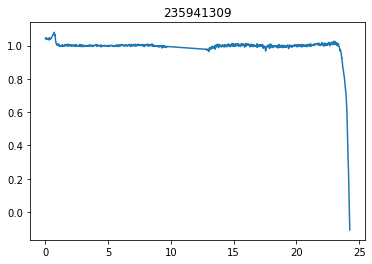

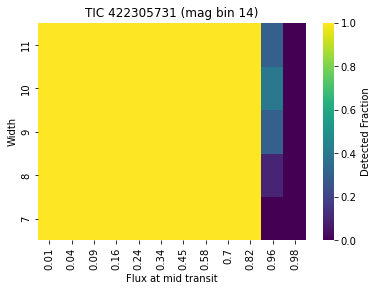

422305731


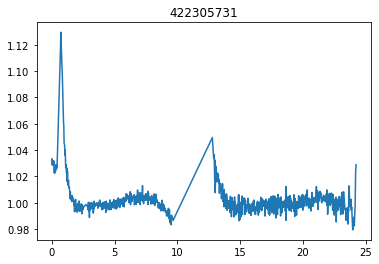

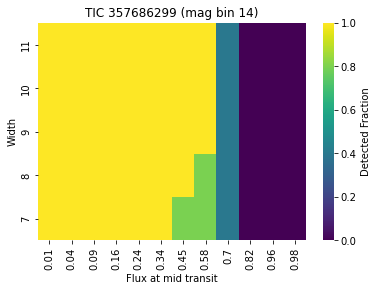

357686299


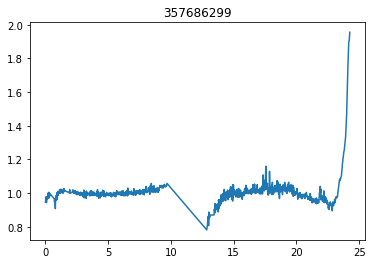

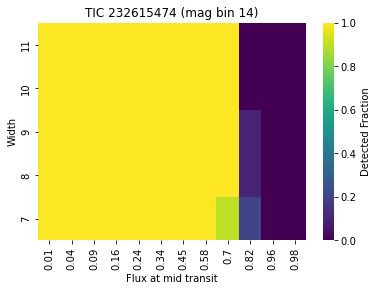

232615474


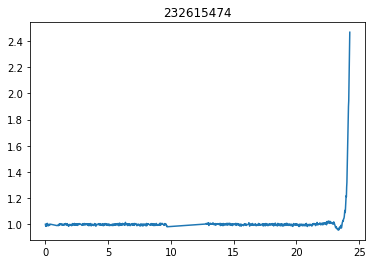

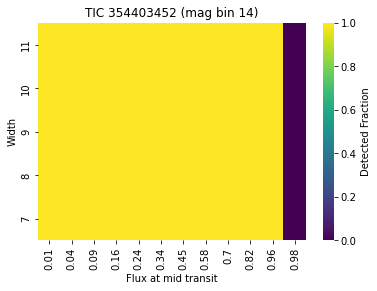

354403452


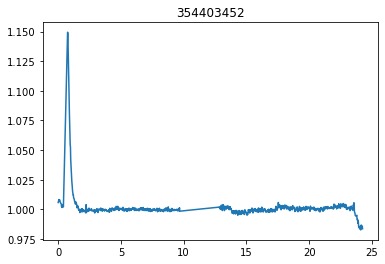

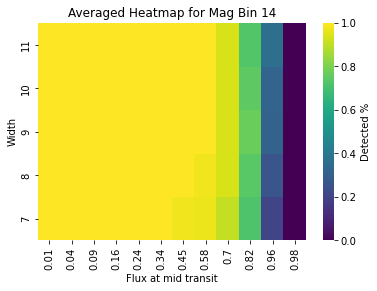

In [ ]:
#to show components
mag_bin = 8 # Write in desired mag bin

folder_path = f'./check_heatmap_data_mag_{mag_bin}/'
average_heatmaps(folder_path, mag_bin, many = True)

#plot lcs

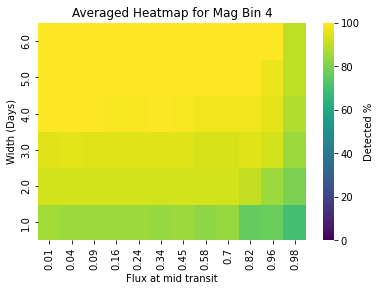

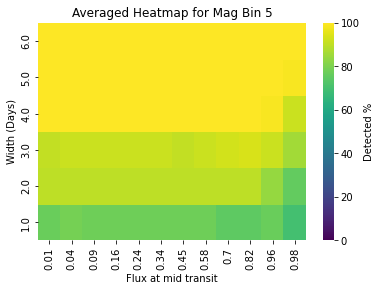

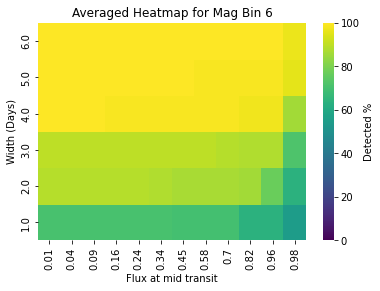

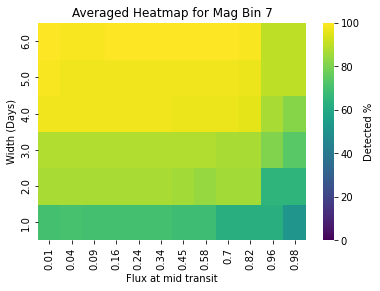

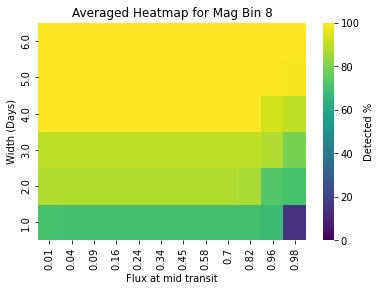

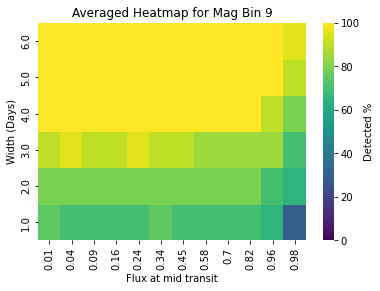

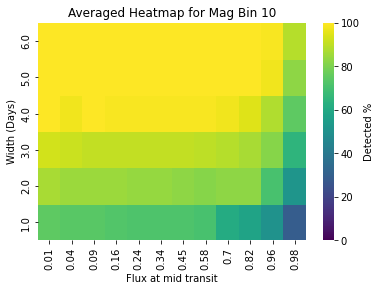

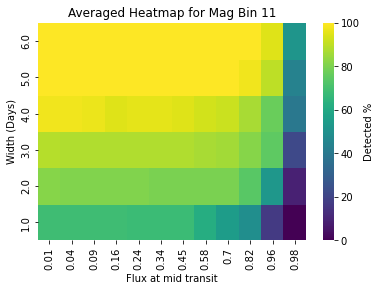

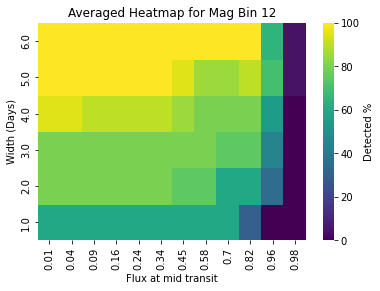

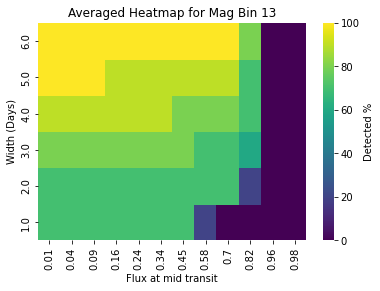

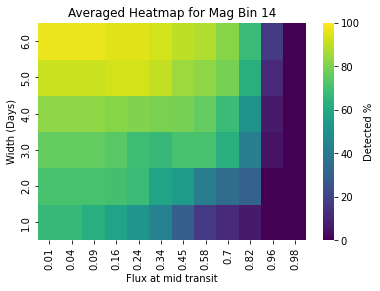

In [18]:
#averaged only
mag_bins = np.arange(4,15)
for mag_bin in mag_bins:
    folder_path = f'./heatmap_data_mag_{mag_bin}/'
    average_heatmaps(folder_path, mag_bin, many = False)

In [141]:
def rand_average_heatmaps(folder_path, mag_bin, many = False):
    heatmap_files = [file for file in os.listdir(folder_path) if file.endswith(f'_heatmap.csv')]
    if len(heatmap_files) == 0:
        print("No heatmap files found in the specified folder.")
        return

    # Initialize an empty DataFrame to store the sum of heatmaps
    sum_heatmap = None

    for file in heatmap_files:
        file_path = os.path.join(folder_path, file)
        data = pd.read_csv(file_path)
        data["Detected"] = data["Detected"].multiply(100)
        #print(data)
        #plt.scatter(data["Width"], data ["Flux at mid transit"])
        flux_bins = [0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0]
        width_bins = [0, 1, 2, 3, 4, 5, 6]
        #print(data.head(50))
        # Bin the DataFrame by Flux and Width
        data['Binned Flux'] = pd.cut(data['Flux at mid transit'], bins=flux_bins)#, labels=False)
        data['Binned Width'] = pd.cut(data['Width'], bins=width_bins)#, labels=False)
        def custom_avg(series):
            non_nan_values = series.dropna()
            if len(non_nan_values) == 0:
                return np.nan
            return np.mean(non_nan_values)

        # Group by Binned Flux and Binned Width, calculate the custom average for Detected
        #data_pivoted = data.groupby(['Binned Width', 'Binned Flux'])['Detected'].agg({'Detected': lambda x: x.mean(skipna=False)}).unstack()
        #print(data_pivoted)
        
        # Group by Binned Flux and Binned Width, calculate the average Detected value
        data_pivoted = data.groupby(['Binned Width', 'Binned Flux'])['Detected'].mean().unstack()
        #print(data_pivoted)
        #print(data_pivoted)
        #print(data_pivoted)
        #print(result)
        
        
        
        
        #data_pivoted = data.pivot("Width", "Flux at mid transit", "Detected")

        
        
        
        # If it's the first file, set the sum_heatmap to the current heatmap
        if sum_heatmap is None:
            sum_heatmap = data_pivoted
        else:
            # Add the current heatmap to the sum_heatmap
            #sum_heatmap += data_pivoted
            sum_heatmap = sum_heatmap.add(data_pivoted, fill_value=0)

        if many == True:
            single_data_pivoted = sns.heatmap(data_pivoted, cmap="viridis", vmin=0, vmax=100)

            plt.title(f"TIC_{file[:-12]} (mag bin {mag_bin})")
            single_data_pivoted.collections[0].colorbar.set_label("Detected Percent")
            single_data_pivoted.invert_yaxis()
            plt.show()
            # tic_id = int(file[:-12])
            # print(tic_id)
            # subref = ref[ref.TIC_ID==tic_id] 
            # f0 = data_dir+subref.Filename.values[0]
            # lc = loaders.load_lc(f0)
            # lc = lc[lc.quality==0]
            # lc = lc.normalize()
            # time = lc.time.value
            # time = [value - time[0] for value in time] #make time start at 0
            # plt.plot(time, lc.flux.value)
            # plt.title(tic_id)
            # plt.show()

    #Calculate the average heatmap by dividing the sum_heatmap by the number of files
    #print(sum_heatmap)
    average_heatmap = sum_heatmap / len(heatmap_files)
    print(average_heatmap)
    # Plot the averaged heatmap
    ax = sns.heatmap(average_heatmap, cmap="viridis", vmin=0, vmax=100)
    plt.title(f"Averaged Heatmap for Mag Bin {mag_bin}")
    plt.xlabel("Flux at mid transit")
    plt.ylabel("Width (Days)")
    ax.invert_yaxis()

    cbar = ax.collections[0].colorbar
    cbar.set_label("Detected %")

    plt.show()

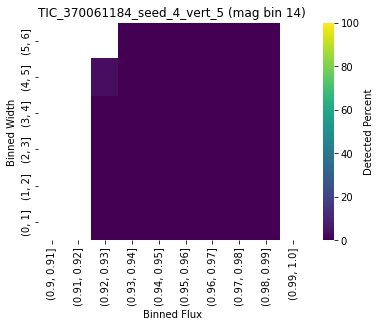

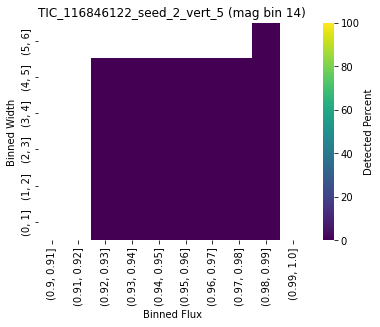

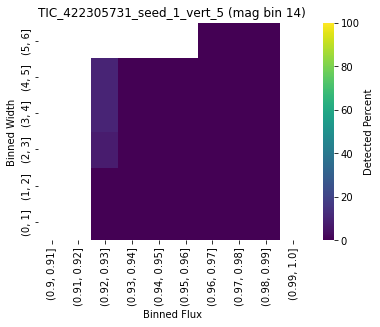

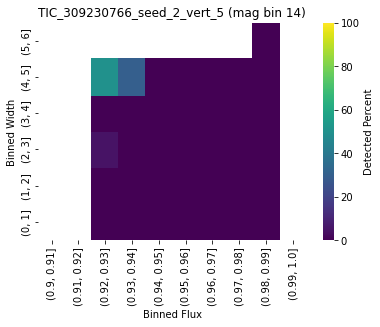

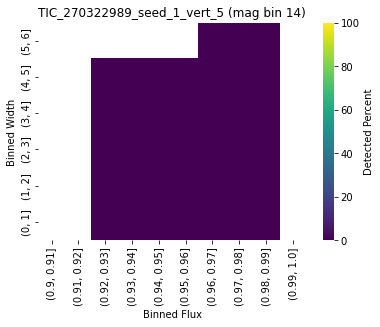

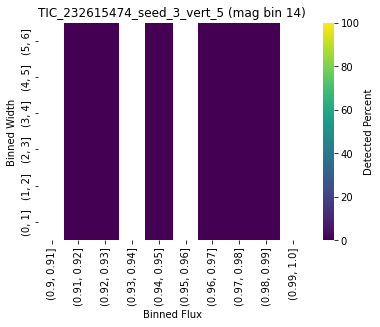

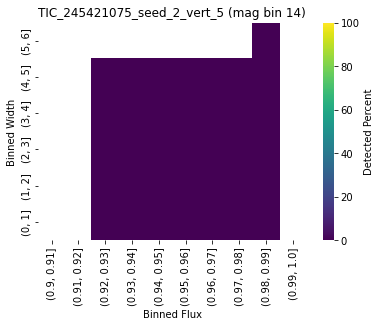

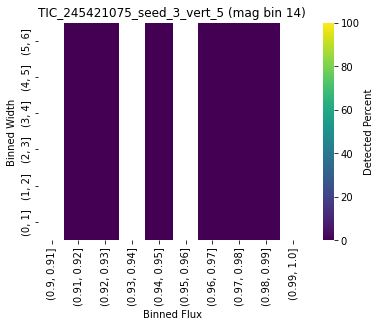

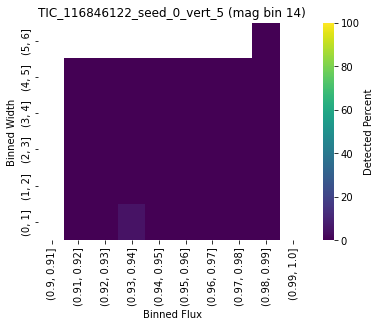

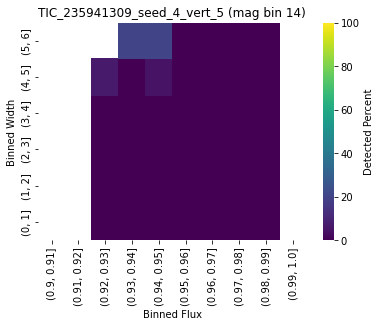

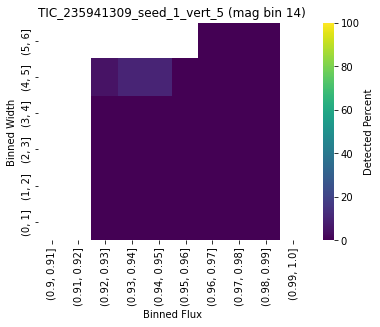

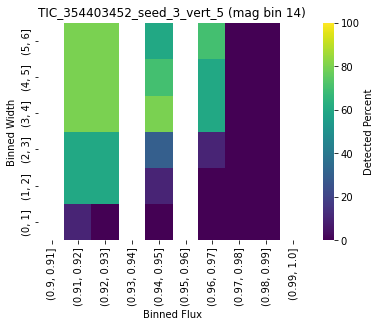

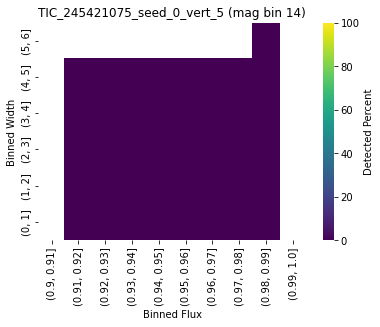

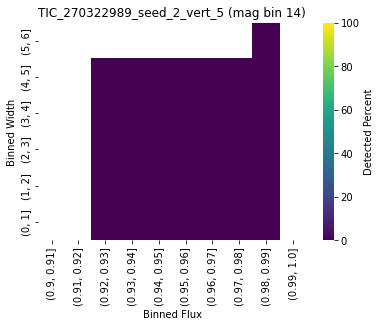

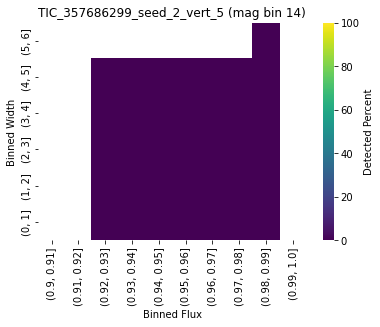

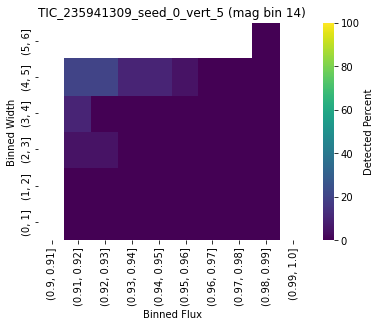

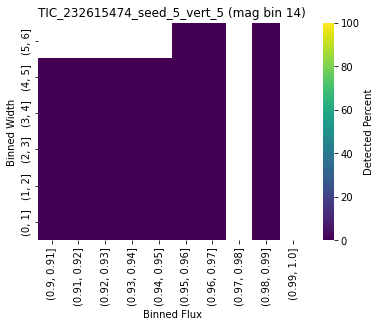

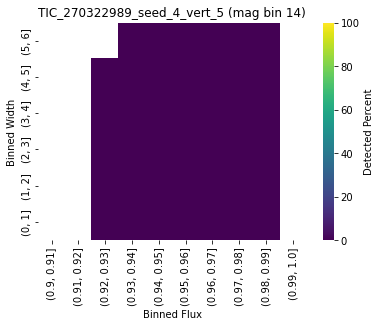

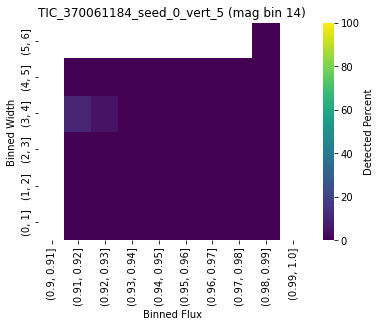

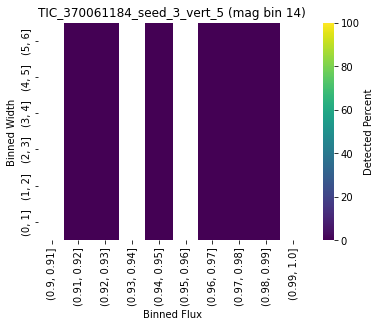

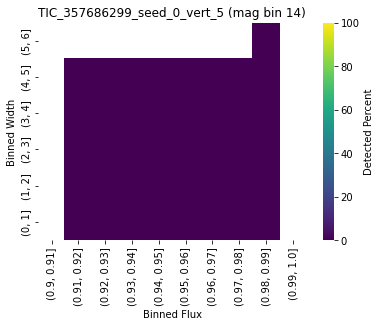

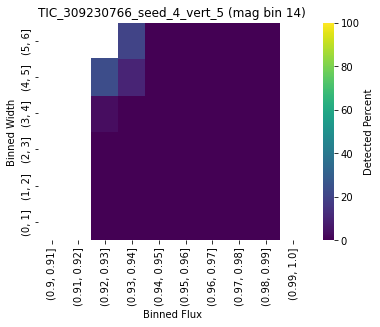

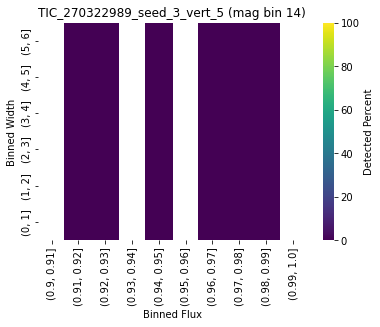

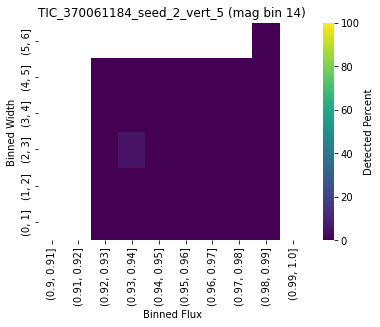

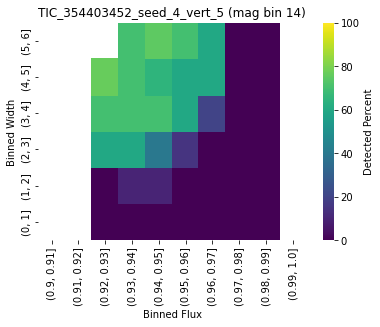

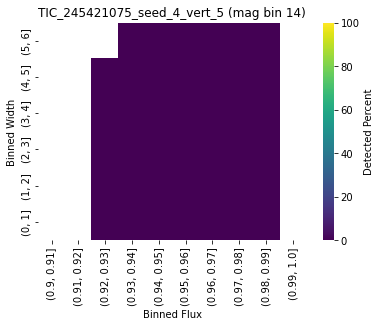

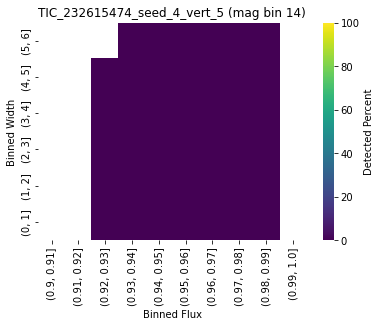

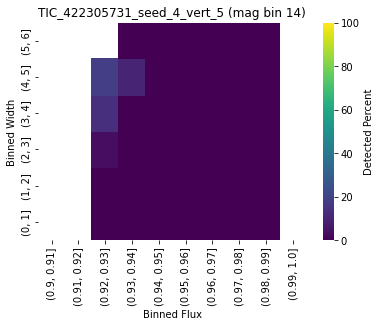

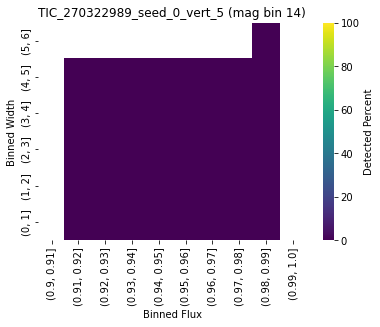

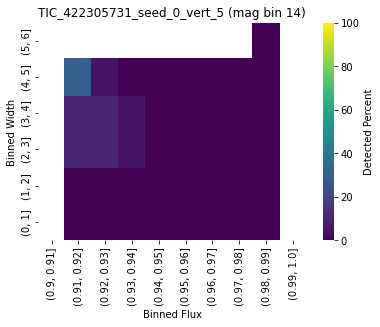

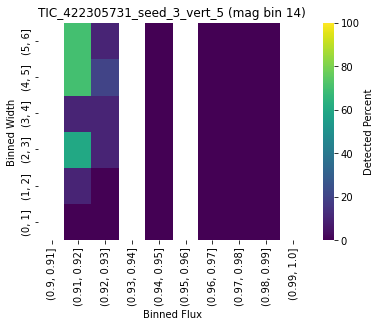

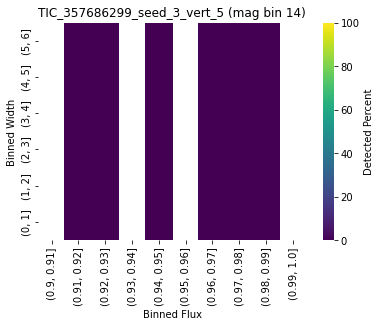

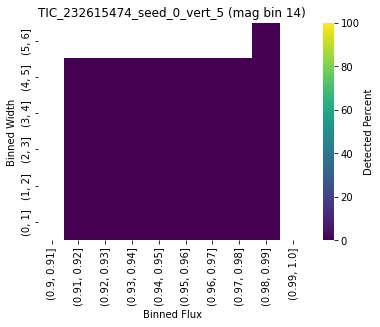

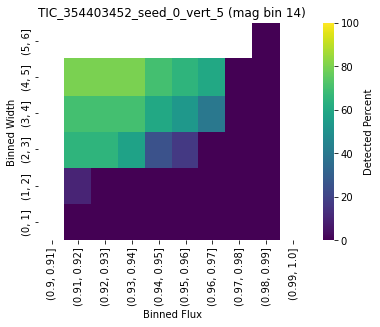

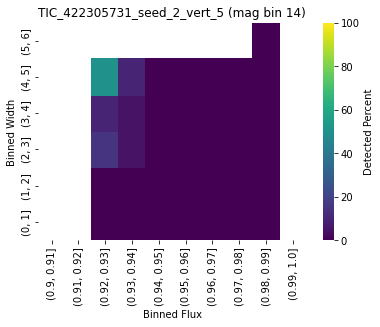

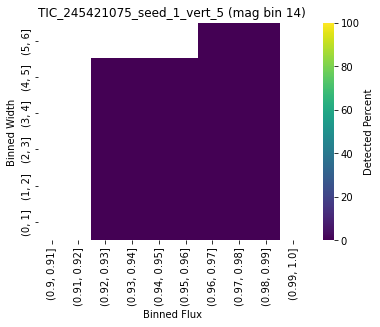

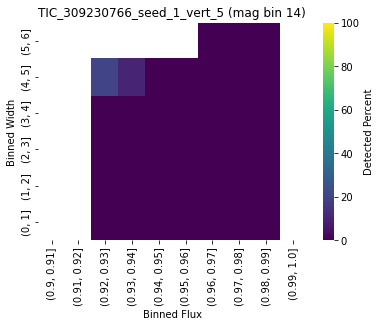

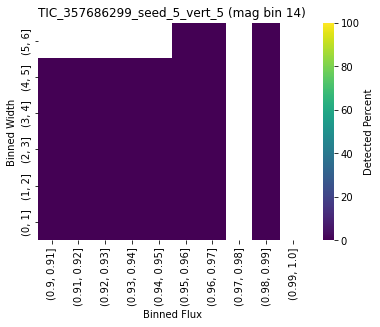

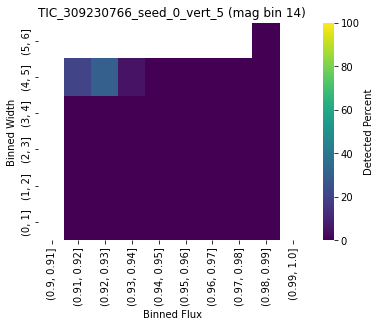

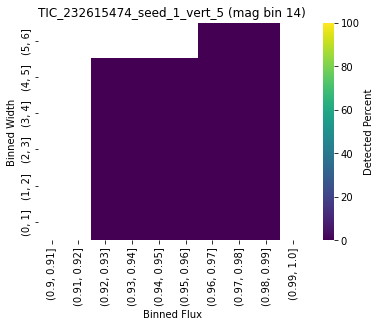

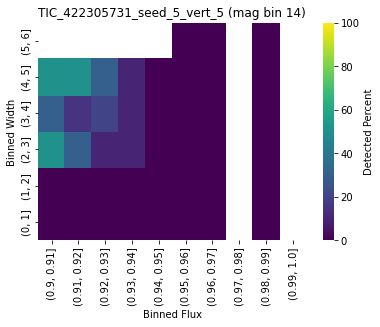

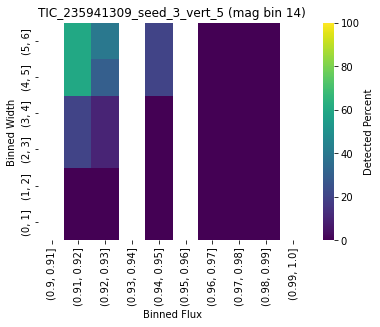

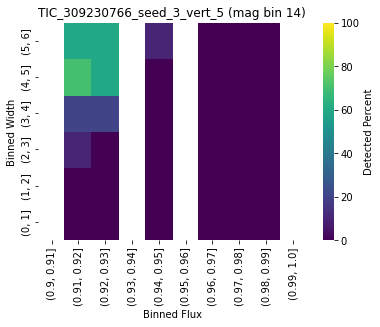

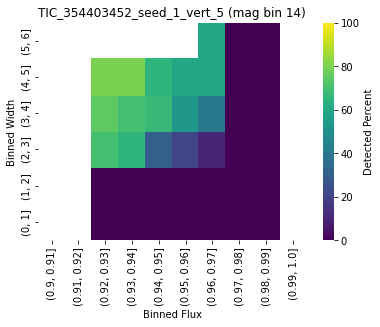

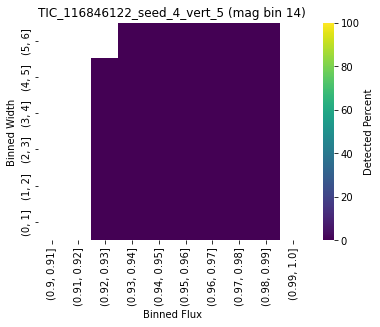

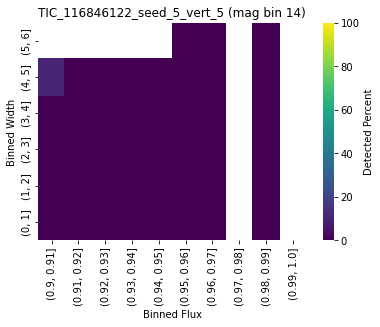

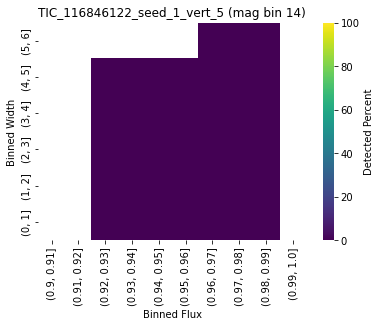

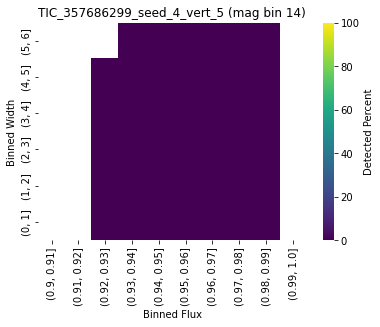

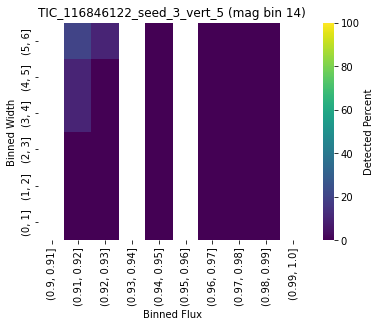

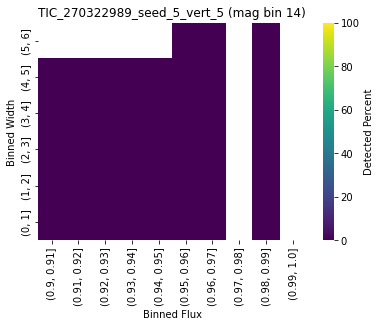

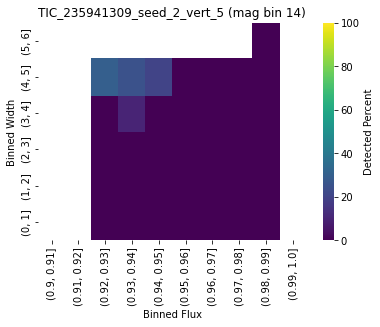

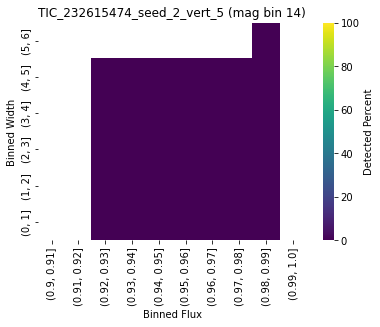

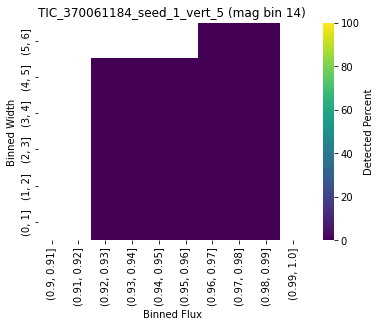

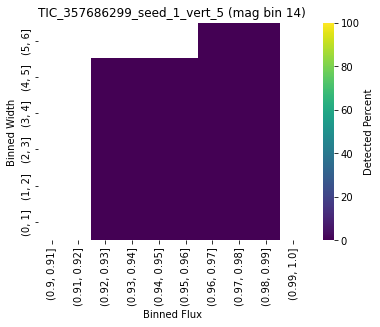

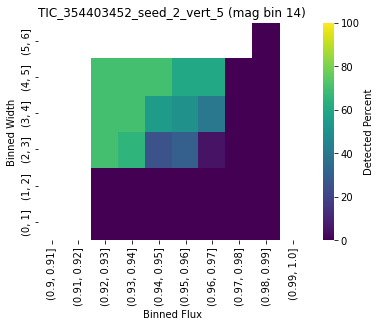

Binned Flux   (0.9, 0.91]  (0.91, 0.92]  (0.92, 0.93]  (0.93, 0.94]  \
Binned Width                                                          
(0, 1]           0.000000      0.181818      0.000000      0.090909   
(1, 2]           0.000000      1.454545      1.090909      0.181818   
(2, 3]           0.909091      4.727273      7.287879      4.954545   
(3, 4]           0.545455      4.636364      8.666667      5.636364   
(4, 5]           1.090909      8.909091     14.515152      7.818182   
(5, 6]                NaN      5.272727      3.636364      2.000000   

Binned Flux   (0.94, 0.95]  (0.95, 0.96]  (0.96, 0.97]  (0.97, 0.98]  \
Binned Width                                                           
(0, 1]            0.000000      0.000000      0.000000           0.0   
(1, 2]            0.363636      0.000000      0.000000           0.0   
(2, 3]            2.727273      1.484848      0.454545           0.0   
(3, 4]            6.045455      3.939394      3.636364           0.0   

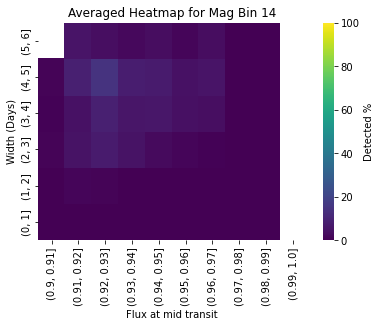

In [143]:
mag_bins = [14]#np.arange(4,15)
for mag_bin in mag_bins:
    folder_path = f'./rand_heatmap_data_mag_{mag_bin}/'
    rand_average_heatmaps(folder_path, mag_bin, many = True)

Binned Flux   (0.9, 0.91]  (0.91, 0.92]  (0.92, 0.93]  (0.93, 0.94]  \
Binned Width                                                          
(0, 1]                NaN           NaN           0.0           5.0   
(1, 2]                NaN           NaN           0.0           0.0   
(2, 3]                NaN           NaN          80.0          62.5   
(3, 4]                NaN           NaN          85.0          75.0   
(4, 5]                NaN           NaN         135.0          95.0   
(5, 6]                NaN           NaN           NaN           NaN   

Binned Flux   (0.94, 0.95]  (0.95, 0.96]  (0.96, 0.97]  (0.97, 0.98]  \
Binned Width                                                           
(0, 1]                 0.0      0.000000           0.0           0.0   
(1, 2]                 0.0      0.000000           0.0           0.0   
(2, 3]                25.0     16.666667           0.0           0.0   
(3, 4]                60.0     53.333333          40.0           0.0   

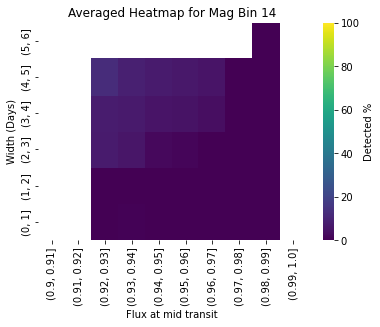

In [68]:
mag_bins = [14]#np.arange(4,15)
for mag_bin in mag_bins:
    folder_path = f'./rand_heatmap_data_mag_{mag_bin}/'
    rand_average_heatmaps(folder_path, mag_bin, many = False)